In [ ]:
author: Diogo Silva

In [2]:
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
from MyML.cluster.K_Means3 import K_Means
import MyML.helper.partition as partMod

In [5]:
n_samples = 1e4
n_samples = int(n_samples)
n_features = 2
n_clusters = 6

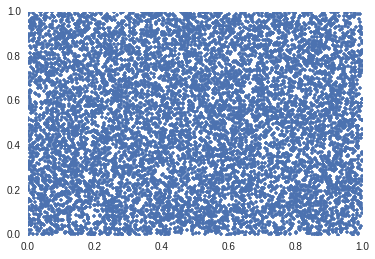

In [7]:
data = np.random.uniform(size=(n_samples, n_features)).astype(np.float32)
plt.plot(data[:,0],data[:,1],'.')

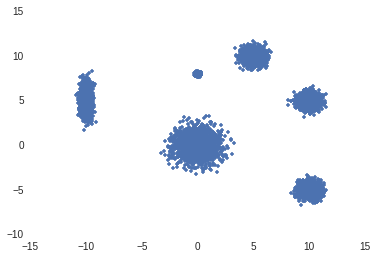

In [34]:
g1 = np.random.normal(loc=(0,0), scale=1, size=(n_samples/n_clusters, n_features))
g2 = np.random.normal(loc=(10,5), scale=0.5, size=(n_samples/n_clusters, n_features))
g3 = np.random.normal(loc=(0,8), scale=0.1, size=(n_samples/n_clusters, n_features))
g4 = np.random.normal(loc=(-10,5), scale=(0.25,1), size=(n_samples/n_clusters, n_features))
g5 = np.random.normal(loc=(5,10), scale=0.5, size=(n_samples/n_clusters, n_features))
g6 = np.random.normal(loc=(10,-5), scale=0.5, size=(n_samples/n_clusters, n_features))

data = np.vstack((g1,g2,g3,g4,g5,g6))
gt = np.empty(data.shape[0], dtype = np.int32)
for i in range(n_clusters):
    gt[g1.shape[0] * i:g1.shape[0] * i + g1.shape[0]] = i

plt.plot(data[:,0],data[:,1],'.')

In [35]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [36]:
foldername = "/home/diogoaos/QCThesis/datasets/gaussmix1e4/"
dataname = "data.csv"
gtname = "ground_truth.csv"

In [37]:
np.savetxt(foldername + dataname, data, delimiter = ",")
np.savetxt(foldername + gtname, gt, delimiter = ",")

In [38]:
data = np.genfromtxt(foldername + dataname, delimiter = ",", dtype = np.float32)

In [8]:
n_partitions = 100
ensemble_clusters = [np.sqrt(n_samples)/2, np.sqrt(n_samples)]
ensemble_clusters = map(int, ensemble_clusters)
generator = K_Means(cuda_mem="manual")

In [40]:
%time partMod.generateEnsembleToFiles(foldername, data, generator, n_clusters=ensemble_clusters, npartitions=n_partitions)

CPU times: user 1.75 s, sys: 154 ms, total: 1.9 s
Wall time: 1.9 s


In [9]:
%time ensemble = partMod.generateEnsemble(data, generator, n_clusters=ensemble_clusters, npartitions=n_partitions)

CPU times: user 1.7 s, sys: 268 ms, total: 1.97 s
Wall time: 1.97 s


# Build co-association matrix

## Load ensemble

In [17]:
import MyML.cluster.eac as eac

In [42]:
reload(eac)

<module 'MyML.cluster.eac' from '/home/diogoaos/QCThesis/MyML/cluster/eac.pyc'>

In [43]:
foldername = "/home/diogoaos/QCThesis/datasets/gaussmix1e4/"

/home/diogoaos/QCThesis/datasets/gaussmix1e4/


In [44]:
ensemble = partMod.loadEnsembleFromFiles(foldername=foldername)

In [18]:
i=0

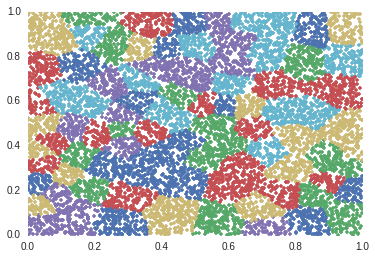

In [20]:
for clust in ensemble[i]:
    plt.plot(data[clust,0], data[clust, 1], '.')
i+=1
if i >= len(ensemble):
    i=0

In [194]:
n_samples = 0
for clust in ensemble[0]:
    n_samples += clust.size
print n_samples

9996


In [67]:
fullEAC = eac.EAC(n_samples = n_samples, mat_sparse = False)

In [68]:
%time fullEAC.fit(ensemble, assoc_mode="full", prot_mode="none")

CPU times: user 3.58 s, sys: 0 ns, total: 3.58 s
Wall time: 3.53 s


Total time = 3.37s

In [69]:
full_nnz = fullEAC._coassoc.nonzero()[0].size
print "full matrix edges/vertices ratio : ", full_nnz * 1.0 / n_samples

full matrix edges/vertices ratio :  1666.0


In [161]:
coassoc = np.zeros((n_samples,n_samples))
%time eac.update_coassoc_with_ensemble(coassoc, ensemble)

CPU times: user 1.99 s, sys: 64.3 ms, total: 2.05 s
Wall time: 2.05 s


Total time = 987 ms

In [163]:
(coassoc == fullEAC._coassoc).all()

True

In [76]:
protEAC = eac.EAC(n_samples = n_samples, mat_sparse = False)

In [77]:
n_prots = int(0.1 * n_samples)
%time protEAC.fit(ensemble, assoc_mode="full", prot_mode="random", nprot=n_prots)

CPU times: user 1.85 s, sys: 7.84 ms, total: 1.86 s
Wall time: 1.86 s


In [78]:
protEAC_nnz = protEAC._coassoc.nonzero()[0].size
print "prot matrix edges/vertices ratio : ", full_nnz * 1.0 / n_samples

prot matrix edges/vertices ratio :  1666.0


Total time = 421 ms

In [79]:
sparseEAC = eac.EAC(n_samples = n_samples, mat_sparse = True)

In [80]:
%time sparseEAC.fit(ensemble, assoc_mode="full")

CPU times: user 13min 58s, sys: 386 ms, total: 13min 58s
Wall time: 13min 58s


Total time = 13min 21s

Save **full** coassoc.

In [115]:
%time np.savetxt(foldername + "full_coassoc.csv", fullEAC._coassoc, fmt="%d", delimiter=",")

CPU times: user 37.4 s, sys: 149 ms, total: 37.5 s
Wall time: 37.5 s


Save **full coassocs** in CSR format.

In [82]:
from scipy.sparse import csr_matrix

In [116]:
%time full_sp = csr_matrix(fullEAC._coassoc)
%time prot_sp = csr_matrix(protEAC._coassoc)

CPU times: user 1.02 s, sys: 56.5 ms, total: 1.08 s
Wall time: 1.08 s
CPU times: user 770 ms, sys: 0 ns, total: 770 ms
Wall time: 771 ms


In [114]:
fullEAC._coassoc[np.diag_indices_from(fullEAC._coassoc)] = 0
protEAC._coassoc[np.diag_indices_from(protEAC._coassoc)] = 0

In [157]:
np.where(fullEAC._coassoc[0:1666,0:1666]==100)[0]

array([   3,   14,   19,   26,   26,   26,   34,   35,   36,   36,   38,
         39,   43,   44,   44,   49,   61,   67,   71,   71,   76,   79,
         85,   86,   86,   86,   87,   89,   92,   95,   95,  100,  102,
        102,  120,  121,  126,  133,  133,  134,  138,  139,  144,  144,
        144,  144,  147,  147,  148,  148,  148,  161,  163,  177,  178,
        178,  188,  188,  188,  189,  191,  192,  194,  196,  199,  203,
        203,  205,  206,  208,  208,  209,  214,  231,  231,  231,  231,
        234,  234,  237,  238,  238,  240,  246,  246,  247,  248,  248,
        248,  249,  259,  261,  261,  264,  267,  267,  273,  291,  291,
        291,  298,  298,  301,  301,  303,  311,  311,  311,  311,  312,
        316,  317,  320,  326,  326,  327,  332,  332,  332,  337,  337,
        337,  342,  344,  344,  350,  357,  357,  371,  372,  380,  386,
        386,  386,  391,  393,  397,  397,  397,  403,  403,  406,  407,
        410,  416,  425,  425,  430,  430,  436,  4

In [491]:
print full_sp.__str__
print prot_sp.__str__

<bound method csr_matrix.__str__ of <9996x9996 sparse matrix of type '<type 'numpy.float32'>'
	with 16254576 stored elements in Compressed Sparse Row format>>
<bound method csr_matrix.__str__ of <9996x9996 sparse matrix of type '<type 'numpy.float32'>'
	with 3084084 stored elements in Compressed Sparse Row format>>


In [117]:
np.savetxt(foldername + "full_dest.csr", full_sp.indices, fmt="%d",delimiter=",")
np.savetxt(foldername + "full_weight.csr", full_sp.data, fmt="%d",delimiter=",")
np.savetxt(foldername + "full_fe.csr", full_sp.indptr, fmt="%d",delimiter=",")

In [118]:
np.savetxt(foldername + "prot_dest.csr", prot_sp.indices, fmt="%d",delimiter=",")
np.savetxt(foldername + "prot_weight.csr", prot_sp.data, fmt="%d",delimiter=",")
np.savetxt(foldername + "prot_fe.csr", prot_sp.indptr, fmt="%d",delimiter=",")

In [ ]:
del full_sp, prot_sp

## Evaluate sparsity with co-associasion threshold

In [21]:
reload(eac)

<module 'MyML.cluster.eac' from '/home/diogoaos/QCThesis/MyML/cluster/eac.pyc'>

In [51]:
fullEAC = eac.EAC(n_samples = n_samples, mat_sparse = False)
%time fullEAC.fit(ensemble, assoc_mode="full", prot_mode="none")

CPU times: user 4.38 s, sys: 35 ms, total: 4.41 s
Wall time: 4.42 s


In [23]:
print fullEAC.getMaxAssocs()[0]
print fullEAC.getNNZAssocs()

1228
8360930


In [53]:
resPD=pd.DataFrame(columns=["col1","col2","col3"])

In [52]:
thresholds = np.arange(0,1.01,0.05)
res = np.empty((thresholds.size, 3))
for i in range(thresholds.size):
    res[i, 0] = thresholds[i]
    fullEAC.apply_threshold(thresholds[i])
    max_assocs, max_idx = fullEAC.getMaxAssocs()
    res[i, 1] = max_assocs
    nnz_pc = fullEAC.getNNZAssocs() / 8533572.0
    res[i, 2] = nnz_pc
    print thresholds[i], max_assocs, nnz_pc

0.0 1228 0.979769081459
0.05 794 0.613603072664
0.1 597 0.471317520963
0.15 496 0.386988004554
0.2 437 0.325645110863
0.25 367 0.276588279797
0.3 335 0.235490132385
0.35 294 0.200629232401
0.4 262 0.17024875398
0.45 232 0.143375599339
0.5 205 0.119374161254
0.55 167 0.0981199900815
0.6 142 0.0794258254339
0.65 121 0.0627570728881
0.7 104 0.0482775559871
0.75 88 0.0357306412836
0.8 76 0.0249665673413
0.85 68 0.0159323668916
0.9 57 0.00891279759519
0.95 38 0.00390621887294
1.0 7 0.0013216036614


In [25]:
import pandas as pd

In [30]:
resPD = pd.DataFrame(res, columns=["threshold","max_assocs", "nnz percent relative to max"])

In [33]:
print resPD.to_latex()

\begin{tabular}{lrrr}
\toprule
{} &  threshold &   max\_assocs &  nnz percent relative to max \\
\midrule
0  &   0.000000 &  1228.000000 &                     0.979769 \\
1  &   0.050000 &   794.000000 &                     0.613603 \\
2  &   0.100000 &   597.000000 &                     0.471318 \\
3  &   0.150000 &   496.000000 &                     0.386988 \\
4  &   0.200000 &   437.000000 &                     0.325645 \\
5  &   0.250000 &   367.000000 &                     0.276588 \\
6  &   0.300000 &   335.000000 &                     0.235490 \\
7  &   0.350000 &   294.000000 &                     0.200629 \\
8  &   0.400000 &   262.000000 &                     0.170249 \\
9  &   0.450000 &   232.000000 &                     0.143376 \\
10 &   0.500000 &   205.000000 &                     0.119374 \\
11 &   0.550000 &   167.000000 &                     0.098120 \\
12 &   0.600000 &   142.000000 &                     0.079426 \\
13 &   0.650000 &   121.000000 &                 

In [ ]:
resPD8

In [35]:
fullEAC._coassoc

array([[ 100.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,  100.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,  100., ...,    0.,    0.,    0.],
       ..., 
       [   0.,    0.,    0., ...,  100.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,  100.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,  100.]], dtype=float32)

In [16]:
fullEAC._coassoc[::100,::100].shape

(100, 100)

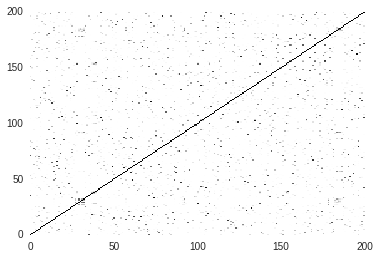

In [18]:
plt.pcolor(fullEAC._coassoc[::50,::50])

In [ ]:
plt.pcolor()

# SL-HAC

In [91]:
from numba import jit

@jit
def outdegree_from_firstedge(firstedge, outdegree, n_edges):
    n_vertices = firstedge.size
    for v in range(n_vertices - 1):
        outdegree[v] = firstedge[v + 1] - firstedge[v]
    outdegree[n_vertices - 1] = n_edges - firstedge[n_vertices - 1]

## Get graph

In [6]:
print foldername

/home/diogoaos/QCThesis/datasets/gaussmix1e4/


In [119]:
%time dest = np.genfromtxt(foldername + "full_dest.csr", dtype = np.int32, delimiter=",")
%time weight = np.genfromtxt(foldername + "full_weight.csr", dtype = np.float32, delimiter=",")
%time fe = np.genfromtxt(foldername + "full_fe.csr", dtype = np.int32, delimiter=",")

CPU times: user 44 s, sys: 784 ms, total: 44.8 s
Wall time: 44.7 s
CPU times: user 39.3 s, sys: 682 ms, total: 40 s
Wall time: 39.9 s
CPU times: user 26.3 ms, sys: 26 µs, total: 26.3 ms
Wall time: 26.3 ms


In [86]:
dest = np.genfromtxt(foldername + "prot_dest.csr", dtype = np.int32, delimiter=",")
weight = np.genfromtxt(foldername + "prot_weight.csr", dtype = np.float32, delimiter=",")
fe = np.genfromtxt(foldername + "prot_fe.csr", dtype = np.int32, delimiter=",")

In [120]:
fe = fe[:-1]

In [121]:
od = np.empty_like(fe)
outdegree_from_firstedge(fe, od, dest.size)

In [126]:
weight = 100 - weight

In [127]:
print "# edges : ", dest.size
print "# vertices : ", fe.size
print "edges/vertices ratio : ", dest.size * 1.0 / fe.size

# edges :  16643340
# vertices :  9996
edges/vertices ratio :  1665.0


In [10]:
from numba import jit
@jit
def outdegree_from_firstedge(firstedge, outdegree, n_edges):
    n_vertices = firstedge.size
    for v in range(n_vertices - 1):
        outdegree[v] = firstedge[v + 1] - firstedge[v]
    outdegree[n_vertices - 1] = n_edges - firstedge[n_vertices - 1]


## Cluster

In [106]:
from numba import cuda
import MyML.graph.mst as myMST
import MyML.graph.build as graphBuild
import MyML.graph.connected_components as ccomps
import MyML.cluster.linkage as linkage

/home/diogoaos/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:106: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


In [136]:
reload(linkage)

<module 'MyML.cluster.linkage' from '/home/diogoaos/QCThesis/MyML/cluster/linkage.pyc'>

In [142]:
%prun linkage.sl_mst_lifetime_gpu(dest, weight, fe, od, disconnect_weight = 100, MAX_TPB=512)

In [140]:
%time labels = linkage.sl_mst_lifetime_gpu(dest, weight, fe, od, disconnect_weight = 100, MAX_TPB=512)

CPU times: user 6.99 s, sys: 2.03 s, total: 9.02 s
Wall time: 9.02 s


## Accuracy

In [149]:
import MyML.metrics.accuracy as accuracy

In [145]:
%time gt = np.genfromtxt(foldername + "ground_truth.csv", dtype = np.int32, delimiter=",")

CPU times: user 35.7 ms, sys: 0 ns, total: 35.7 ms
Wall time: 34.6 ms


In [151]:
scorer = accuracy.HungarianIndex(nsamples=gt.size)
%time scorer.score(gt, labels)

CPU times: user 83.2 ms, sys: 179 µs, total: 83.4 ms
Wall time: 73.7 ms


/home/diogoaos/QCThesis/MyML/helper/partition.py:57: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if clusts == None:


In [152]:
print scorer.accuracy

1.0
